In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The goal of this simulation is to answer the questions, "How long will the COVID-19 pandemic last?" and "How many people are infected right now in my local area but do not know it?"

We are making the code available, because we are not sure we believe this simulation. We want data scientists to critique the assumptions and how the code works to iterate towards the most useful and realistic model we can get.

This is a very emotional and human issue.  But the assumptions we put into the model are numbers, and the code is code. So while doing this data science work, it is important to view the code, inputs, and results with a kind of clinical emotional distance.

For example, to make mathematical modeling easier, the model assumes that if one person in a household gets sick, so does everyone else in that household. On a personal basis, I hope that is not true for your household.  As a simplified mathematical model, we treat a household where a group of people may be sheltering in place or self-quarantining as if it were a single person.

Before we get into the details of the code and the assumptions, the high level conclusion is this: There are two regimes.  In one regime, people are very careful about staying at home and not spreading the disease  The curve spreads out over a 100 day period.  The other regime is where people are a bit less careful.  In this regime, the disease doubles every 4 days in the population.  Since it takes an average of 6.5-7 days to express symptoms, the virus can spread to 4x more people before the people who transmitted it feel any symptoms.


Let's talk through the code now.  I have been basing ny numerical assumptions on this Medium article, but the goal of this to create a code artifact that anyone can use to try out their assumptions:  https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca

The model assumes that there are two kinds of households, "home" and "moving." A "moving" household is a household where one or more people in the household have a job where they move around in the community.  This includes people who are delivering food, bagging or boxing food in distribution centers, police, firemen, doctors, nurses, grocery store workers, and so forth. 

The other kind of household, "home", stays in their house, receives deliveries of food or other necessities, and practices social distancing (6+ feet) if they go for a walk outside.  They make decisions like whether to order take-out, whether to treat Amazon or Instacart type deliveries with dilute bleach or let non-perishables with hard surfaces sit for 2 days, etc.  They also decide whether to go see their "best friend" once every 10 days.  These are the critical decisions.

This split into two kinds of households, is what I see when I look out of my window in Cambridge, MA.  Then I found the paper from the Centre for Mathematical Modelling of Infectious Diseases, London School of Hygiene & Tropical Medicine cited below.  They independently did the same exact thing in their model. 

You can put whatever assumptions into the model that you want, but here is how I thought about putting in assumptions.  Here is how I thought about the range of pessimistic assumptions versus optimistic assumptions:

1 in every 10 days a home person who is incubating the virus visits a friend because they have cabin fever and in 1/1 of those visits transmits the disease.  That measn on average, 1 in every 10 days a given home household spreads the disease to some other home household.  A more optimistic assumption would put this number at 1 in every 100 days.

1 in every 5 days a instacart delivery person or a plumber or a cleaning person whatever provides the virus to a home via a surface or a brief failure of social distancing, and 50% of those incidents transmit the disease.  This means probability each day that a mobile household transmits COVID-19 to a home household would be 0.1.  Which would mean that one in ten days a transmission occurs from a given mobile household to some home household they deliver to.  A more optimistic assumption would put this number at 1 in every 100 days that a given moving delivery person or care giver transmmits the desease to one of the homes they help support.

I assume that "home" households that have symptoms will take very strong precautions not to get mobile workers sick, so there is zero transfer from home_sick to moving.

I assume that because the US government has been vague about financial relief for moving workers who don't or cannot go to work, and because many doctors, nurses, food delivery people, and so forth are very dedicated to helping others, 1 out of every 10 mobile workers unfortunately decide to go to work even if they have some symptoms. With a dry cough, they might have 50% chance of infecting a home each day and a 50% chance of infecting another mobile worker each day.  Who knows what those numbers really are.  I just put some in.  BUT, what the model shows is that it doesn't matter what these numbers are unless you are prepared to make them at least 10x more optimistic than this.  There is a critical threshold of mobile workers ignoring their symptoms, where the virus spreads like wildfire.

The results are hard to believe so I am looking for people to comb over the code.  What they say right now, is that unless we use the most optimistic assumptions, AND which seem to me to enforce unrealistically draconian constraints on people, the virus doubles in the population every 4 days, no one knows it is happening until an average of 7 days later when they all start to exhibit symptoms, and there is a tremendous spike in hospitalization which completely overwhelm the medical facilities, and the fatality rate is the fatalility rate of a country that does not have any respirators which right now looks to be in the 2-4% range.  4.5M people die in the US in the next 65 days.  The death experience is one of slow asphyxiation, like slowly drowning over a period of 4 days.

The effect of control strategies that reduce social mixing on outcomes of the COVID-19 epidemic in Wuhan, China, Kiesha Prem, Yang Liu, Timothy W Russell1, Adam J Kucharski, Rosalind M Eggo, Nicholas Davies, Centre for the Mathematical Modelling of Infectious Diseases COVID-19 Working Group, Mark Jit, Petra Klepac



In [2]:
from pprint import pprint
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import string

import math
from math import log
from math import exp
import random

import numpy as np

# Simple model for pedagogy

In [ ]:
home_incubating_to_home_incubating = 1
home_sick_to_home_incubating = 1
home_incubating_to_moving_incubating = 0 
home_sick_to_moving_incubating = 0

home_sick_to_home_dead = 0.04
home_sick_to_home_recovered = 0.96
moving_sick_to_moving_dead = 0.04
moving_sick_to_moving_recovered = 0.96

percent_of_recovered_who_do_not_get_reinfected = 0.998
total_households = 100000

num_days = 200

# Starting March 5
home_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50] + [0]*(num_days)
# big assumption: how many hidden cases corresponded to the visible cases during the same time period:
home_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
home_dead = [0]*7 + [0]*(num_days)
home_recovered = [0]*7 + [0]*(num_days)


for day in range(9, num_days):

    home_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_home_incubating
    home_incubating[day+1] += sum(home_sick[day-9: day])*home_sick_to_home_incubating
    
    # people who have been incubating for 2 to 12 days move to being "sick," with or without symptoms
    # FIXME: should we assume a cleanly separated bucket for every asymptomatic incubator becoming a "sick" person?
    # This model currently assumes that everyone who gets infected, eventually after 12 days moves to a bucket called "sick" people
    # Over the 10 day period from day 2 to day 12 of incubation, 1/10 of them convert to this sick bucket each day.
    home_sick_new = 0
    for i in range(2,12):
        if (day+1-i >=0):
            home_sick_new += home_incubating[day+1-i]/10
    home_sick[day+1] = home_sick_new

    
    # people who have been sick die or recover
    if day-11 >= 0:
        home_dead[day+1] = home_sick[day-11]*home_sick_to_home_dead
        home_recovered[day+1] = home_sick[day-11]*home_sick_to_home_recovered

    # we must remove from the population people who are either now recovered or who have died
    home_not_yet_infected = total_households - sum(home_dead) - sum(home_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(home_sick) - sum(home_incubating)
    if home_not_yet_infected < 0:
        home_not_yet_infected = 0
        
    if home_incubating[day+1] > home_not_yet_infected:
        home_incubating[day+1] = home_not_yet_infected
        
print(int(sum(home_incubating)), '\n')
print(int(sum(home_recovered)), '\n')
print(int(sum(home_dead)), '\n')

# The goal here is a model that is as simple as possible but no simpler.  

It is important not only that the model makes good predictions, but we also need to be able to understand the model so that we can continue to improve it, and understand the assumptions it is making.

Since every hour counts to get information to busines and policy leaders via our partners at the World Economic Forum, who can then help influence the behavior of the population to save lives, we decided better to post embarrassingly simple model to the community sooner, and have people collaborate to improve it, rather than hold the model back while working in private to make it perfect. 

There are already highly expert efforts in London and at Carnegie Mellon working with the WHO and CDC.  They have model code that is not available in the open.  We respect those expert efforts.  Their results may be more accurate, but we have no way of playing with the assumptions of those models or seeing how they arrive at their conclusions.  The intention here is an entirely different approach to the data science.  Our goal here is to leverage the open source data science community.  

# These parameters represent what would have happened in Cambridge if no one had changed their behavior from normal behavior

In [39]:
home_incubating_to_home_incubating = 0.3
moving_incubating_to_home_incubating = 0.3
home_sick_to_home_incubating = 0.3
moving_sick_to_home_incubating = 0.3

home_incubating_to_moving_incubating = 0.3
moving_incubating_to_moving_incubating = 0.3
home_sick_to_moving_incubating = 0.3
moving_sick_to_moving_incubating = 0.3

home_sick_to_home_dead = 0.04
home_sick_to_home_recovered = 0.96
moving_sick_to_moving_dead = 0.04
moving_sick_to_moving_recovered = 0.96

percent_of_recovered_who_do_not_get_reinfected = 0.998

total_households = 1e5
percent_of_households_with_person_moving = 0.25
households_moving = total_households*percent_of_households_with_person_moving
households_home = total_households*(1-percent_of_households_with_person_moving)

num_days = 60

# Starting March 5
home_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
moving_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
home_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50] + [0]*(num_days)
moving_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50]+ [0]*(num_days)
home_dead = [0]*7 + [0]*(num_days)
moving_dead = [0]*7 + [0]*(num_days)
home_recovered = [0]*7 + [0]*(num_days)
moving_recovered = [0]*7 + [0]*(num_days)


for day in range(9, num_days):

    home_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_home_incubating
    home_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_home_incubating
    home_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_home_incubating
    home_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_home_incubating

    moving_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_moving_incubating
    moving_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_moving_incubating

    
    # people who have been incubating for 2 to 12 days get sick
    home_sick_new = 0
    moving_sick_new = 0
    for i in range(2,12):
        if (day+1-i >=0):
            home_sick[day+1] += home_incubating[day+1-i]/10
            moving_sick[day+1] += moving_incubating[day+1-i]/10
    
    
    # people who have been sick die or recover
    if day-11 >= 0:
        home_dead[day+1] = home_sick[day-11]*home_sick_to_home_dead
        home_recovered[day+1] = home_sick[day-11]*home_sick_to_home_recovered
        
        moving_dead[day+1] = moving_sick[day-11]*moving_sick_to_moving_dead 
        moving_recovered[day+1] = moving_sick[day-11]*moving_sick_to_moving_recovered

        
    # we must remove from the population people who are either now recovered or who have died
    home_not_yet_infected = total_households - sum(home_dead) - sum(home_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(home_sick) - sum(home_incubating)
    if home_not_yet_infected < 0:
        home_not_yet_infected = 0
        
    if home_incubating[day+1] > home_not_yet_infected:
        home_incubating[day+1] = home_not_yet_infected
        

    # we must remove from the population people who are either now recovered or who have died
    moving_not_yet_infected = total_households - sum(moving_dead) - sum(moving_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(moving_sick) - sum(moving_incubating)
    if moving_not_yet_infected < 0:
        moving_not_yet_infected = 0
        
    if moving_incubating[day+1] > moving_not_yet_infected:
        moving_incubating[day+1] = moving_not_yet_infected

# Plotting functions

number of newly infected people each day


Text(0, 0.5, 'number of households')

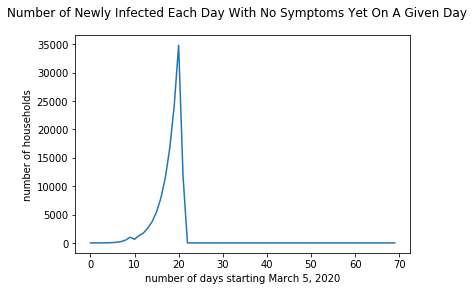

In [40]:
print('number of newly infected people each day')
total_incubating = [0]*len(home_incubating)
for i in range(len(home_incubating)):
    total_incubating [i] = int(home_incubating[i] + moving_incubating[i])
# pprint(total_incubating)
# print('\n')

x = list(range(len(total_incubating)))

fig = plt.figure()
plt.plot(x, total_incubating)
# plt.plot(x, home_incubating, moving_incubating)
fig.suptitle('Number of Newly Infected Each Day With No Symptoms Yet On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')


Text(0, 0.5, 'number of households')

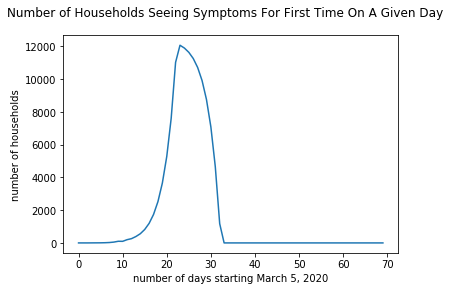

In [41]:
# print('number of newly symptomatic people each day')
total_sick = [0]*len(home_sick)
for i in range(len(home_sick)):
    total_sick[i] = int(home_sick[i] + moving_sick[i])
# pprint(total_sick)
# print('\n')

x = list(range(len(total_sick)))

fig = plt.figure()
plt.plot(x, total_sick)
fig.suptitle('Number of Households Seeing Symptoms For First Time On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')

Text(0, 0.5, 'number of households')

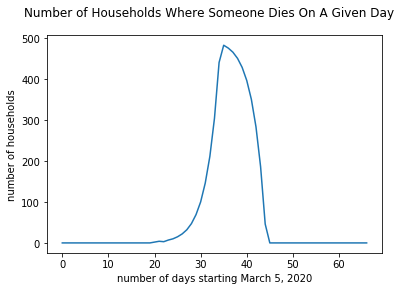

In [42]:
# print('number of newly dead people each day')
total_dead = [0]*len(home_dead)
for i in range(len(home_dead)):
    total_dead[i] = int(home_dead[i] + moving_dead[i])
# pprint(total_dead)
# print('\n')

x = list(range(len(total_dead)))

fig = plt.figure()
plt.plot(x, total_dead)
fig.suptitle('Number of Households Where Someone Dies On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')

# This is the model with people being about as careful as they are now about social distancing and self-quarantining

In [47]:
home_incubating_to_home_incubating = 0.03
moving_incubating_to_home_incubating = 0.03
home_sick_to_home_incubating = 0
moving_sick_to_home_incubating = 0.01

home_incubating_to_moving_incubating = 0 
moving_incubating_to_moving_incubating = 0.2 
home_sick_to_moving_incubating = 0
moving_sick_to_moving_incubating = 0.05

home_sick_to_home_dead = 0.04
home_sick_to_home_recovered = 0.96
moving_sick_to_moving_dead = 0.04
moving_sick_to_moving_recovered = 0.96

percent_of_recovered_who_do_not_get_reinfected = 1

total_households = 1e5
percent_of_households_with_person_moving = 0.25
households_moving = total_households*percent_of_households_with_person_moving
households_home = total_households*(1-percent_of_households_with_person_moving)

num_days = 60

# Starting March 5
home_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
moving_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
home_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50] + [0]*(num_days)
moving_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50]+ [0]*(num_days)
home_dead = [0]*7 + [0]*(num_days)
moving_dead = [0]*7 + [0]*(num_days)
home_recovered = [0]*7 + [0]*(num_days)
moving_recovered = [0]*7 + [0]*(num_days)


for day in range(9, num_days):

    home_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_home_incubating
    home_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_home_incubating
    home_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_home_incubating
    home_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_home_incubating
#     print(home_incubating[day+1])
    
    moving_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_moving_incubating
    moving_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_moving_incubating
#     print(moving_incubating[day+1])

    
    # people who have been incubating for 2 to 12 days get sick
    home_sick_new = 0
    moving_sick_new = 0
    for i in range(2,12):
        if (day+1-i >=0):
            home_sick[day+1] += home_incubating[day+1-i]/10
            moving_sick[day+1] += moving_incubating[day+1-i]/10

    
    
    # people who have been sick die or recover
    if day-11 >= 0:
        home_dead[day+1] = home_sick[day-11]*home_sick_to_home_dead
        home_recovered[day+1] = home_sick[day-11]*home_sick_to_home_recovered
        
        moving_dead[day+1] = moving_sick[day-11]*moving_sick_to_moving_dead 
        moving_recovered[day+1] = moving_sick[day-11]*moving_sick_to_moving_recovered
#     print(moving_dead[day+1])
#     print(moving_recovered[day+1] )
        
        
    # we must remove from the population people who are either now recovered or who have died
    home_not_yet_infected = total_households - sum(home_dead) - sum(home_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(home_sick) - sum(home_incubating)
    if home_not_yet_infected < 0:
        home_not_yet_infected = 0
        
    if home_incubating[day+1] > home_not_yet_infected:
        home_incubating[day+1] = home_not_yet_infected
        

    # we must remove from the population people who are either now recovered or who have died
    moving_not_yet_infected = total_households - sum(moving_dead) - sum(moving_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(moving_sick) - sum(moving_incubating)
    if moving_not_yet_infected < 0:
        moving_not_yet_infected = 0
        
    if moving_incubating[day+1] > moving_not_yet_infected:
        moving_incubating[day+1] = moving_not_yet_infected

# Plotting functions

number of newly infected people each day


Text(0, 0.5, 'number of households')

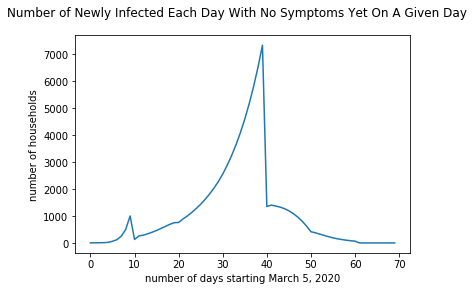

In [48]:
print('number of newly infected people each day')
total_incubating = [0]*len(home_incubating)
for i in range(len(home_incubating)):
    total_incubating [i] = int(home_incubating[i] + moving_incubating[i])
# pprint(total_incubating)
# print('\n')

x = list(range(len(total_incubating)))

fig = plt.figure()
plt.plot(x, total_incubating)
# plt.plot(x, home_incubating, moving_incubating)
fig.suptitle('Number of Newly Infected Each Day With No Symptoms Yet On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')


Text(0, 0.5, 'number of households')

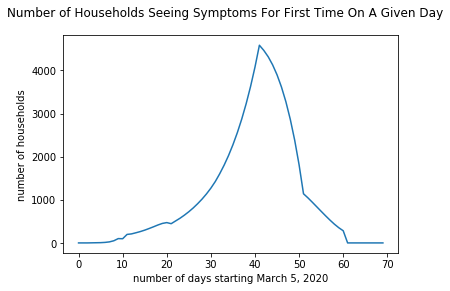

In [49]:
# print('number of newly symptomatic people each day')
total_sick = [0]*len(home_sick)
for i in range(len(home_sick)):
    total_sick[i] = int(home_sick[i] + moving_sick[i])
# pprint(total_sick)
# print('\n')

x = list(range(len(total_sick)))

fig = plt.figure()
plt.plot(x, total_sick)
fig.suptitle('Number of Households Seeing Symptoms For First Time On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')

In [52]:
4500*.05

225.0

# Conclusion:

## *This curve says that given how people are behaving now, there will be a day at the peak in late April when 100,000 households in Cambridge and Arlington MA will yield 4,500 new symptomatic cases in one day.  If 5% of those are serious cases, the hospitals will be admitting 225 serious cases per day at the peak, and will average on the order of 100 new serious cases per day for a twenty day period.  Given over a million households in the Boston area, that is on the order of 2,000 new serious cases per day for twenty days.  That is 40,000 serious cases in the Boston area in a very short period.  We do not have that many ventialtors.  The hospitals will still be over-run.*

Text(0, 0.5, 'number of households')

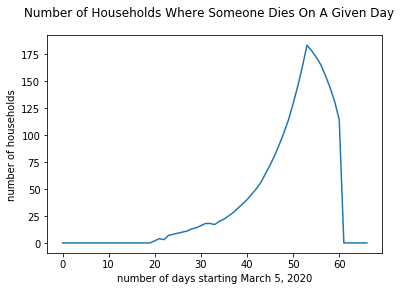

In [50]:
# print('number of newly dead people each day')
total_dead = [0]*len(home_dead)
for i in range(len(home_dead)):
    total_dead[i] = int(home_dead[i] + moving_dead[i])
# pprint(total_dead)
# print('\n')

x = list(range(len(total_dead)))

fig = plt.figure()
plt.plot(x, total_dead)
fig.suptitle('Number of Households Where Someone Dies On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')

# Here's how strong the social distancing behavior would have to be in order to flatten the curve.

## Each staying home household only transmits the virus to another staying home household once every 20 days.  So no going for walks with your best friend once every day or even every week.  You can only do that once per month if you are going to transmit the virus to them while you are with them.

## A given moving/mobile worker like a food delivery person, must only communicate the virus to a stay at home household once every 20 days.  With all of the bags being carried and all of the individual fruits being picked up and put into bags by workers who might be incubating the virus, and with a delivery person delivering to 10-20 households per day, this can only result in a household getting infected from one of these deliveries once every 20 days.

## The mobile workers need to be very careful as well.  If they are together at a grocery store or packing warehouse, a given worker can only transmit the virus to another worker once every 10 days.

In [74]:
home_incubating_to_home_incubating = 0.05
moving_incubating_to_home_incubating = 0.05
home_sick_to_home_incubating = 0
moving_sick_to_home_incubating = 0.05

home_incubating_to_moving_incubating = 0 
moving_incubating_to_moving_incubating = 0.1
home_sick_to_moving_incubating = 0
moving_sick_to_moving_incubating = 0.05

home_sick_to_home_dead = 0.04
home_sick_to_home_recovered = 0.96
moving_sick_to_moving_dead = 0.04
moving_sick_to_moving_recovered = 0.96

percent_of_recovered_who_do_not_get_reinfected = 1

total_households = 1e5
percent_of_households_with_person_moving = 0.25
households_moving = total_households*percent_of_households_with_person_moving
households_home = total_households*(1-percent_of_households_with_person_moving)

num_days = 200

# Starting March 5
home_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
moving_incubating = [1, 2, 3, 5, 10, 30, 60, 125, 250, 500] + [0]*(num_days)
home_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50] + [0]*(num_days)
moving_sick = [0, 0, 0, 1, 2, 3, 6, 12, 25, 50]+ [0]*(num_days)
home_dead = [0]*7 + [0]*(num_days)
moving_dead = [0]*7 + [0]*(num_days)
home_recovered = [0]*7 + [0]*(num_days)
moving_recovered = [0]*7 + [0]*(num_days)


for day in range(9, num_days):

    home_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_home_incubating
    home_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_home_incubating
    home_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_home_incubating
    home_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_home_incubating
#     print(home_incubating[day+1])
    
    moving_incubating[day+1] = sum(home_incubating[day-9: day])*home_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(moving_incubating[day-9: day])*moving_incubating_to_moving_incubating
    moving_incubating[day+1] += sum(home_sick[day-4: day])*home_sick_to_moving_incubating
    moving_incubating[day+1] += sum(moving_sick[day-4: day])*moving_sick_to_moving_incubating
#     print(moving_incubating[day+1])

    
    # people who have been incubating for 2 to 12 days get sick
    home_sick_new = 0
    moving_sick_new = 0
    for i in range(2,12):
        if (day+1-i >=0):
            home_sick[day+1] += home_incubating[day+1-i]/10
            moving_sick[day+1] += moving_incubating[day+1-i]/10

    
    
    # people who have been sick die or recover
    if day-11 >= 0:
        home_dead[day+1] = home_sick[day-11]*home_sick_to_home_dead
        home_recovered[day+1] = home_sick[day-11]*home_sick_to_home_recovered
        
        moving_dead[day+1] = moving_sick[day-11]*moving_sick_to_moving_dead 
        moving_recovered[day+1] = moving_sick[day-11]*moving_sick_to_moving_recovered
#     print(moving_dead[day+1])
#     print(moving_recovered[day+1] )
        
        
    # we must remove from the population people who are either now recovered or who have died
    home_not_yet_infected = total_households - sum(home_dead) - sum(home_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(home_sick) - sum(home_incubating)
    if home_not_yet_infected < 0:
        home_not_yet_infected = 0
        
    if home_incubating[day+1] > home_not_yet_infected:
        home_incubating[day+1] = home_not_yet_infected
        

    # we must remove from the population people who are either now recovered or who have died
    moving_not_yet_infected = total_households - sum(moving_dead) - sum(moving_recovered)*percent_of_recovered_who_do_not_get_reinfected - sum(moving_sick) - sum(moving_incubating)
    if moving_not_yet_infected < 0:
        moving_not_yet_infected = 0
        
    if moving_incubating[day+1] > moving_not_yet_infected:
        moving_incubating[day+1] = moving_not_yet_infected

# Plotting functions

number of newly infected people each day


Text(0, 0.5, 'number of households')

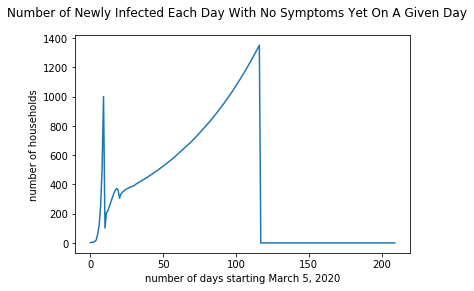

In [75]:
print('number of newly infected people each day')
total_incubating = [0]*len(home_incubating)
for i in range(len(home_incubating)):
    total_incubating [i] = int(home_incubating[i] + moving_incubating[i])
# pprint(total_incubating)
# print('\n')

x = list(range(len(total_incubating)))

fig = plt.figure()
plt.plot(x, total_incubating)
# plt.plot(x, home_incubating, moving_incubating)
fig.suptitle('Number of Newly Infected Each Day With No Symptoms Yet On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')


Text(0, 0.5, 'number of households')

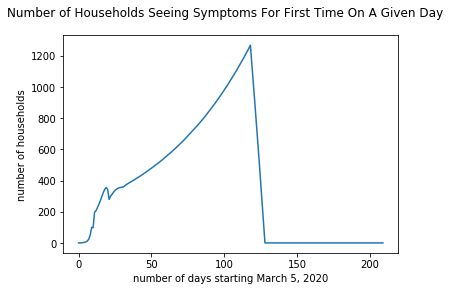

In [76]:
# print('number of newly symptomatic people each day')
total_sick = [0]*len(home_sick)
for i in range(len(home_sick)):
    total_sick[i] = int(home_sick[i] + moving_sick[i])
# pprint(total_sick)
# print('\n')

x = list(range(len(total_sick)))

fig = plt.figure()
plt.plot(x, total_sick)
fig.suptitle('Number of Households Seeing Symptoms For First Time On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')

Text(0, 0.5, 'number of households')

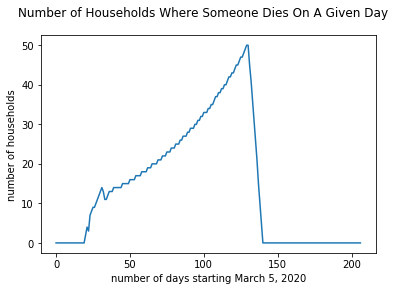

In [77]:
# print('number of newly dead people each day')
total_dead = [0]*len(home_dead)
for i in range(len(home_dead)):
    total_dead[i] = int(home_dead[i] + moving_dead[i])
# pprint(total_dead)
# print('\n')

x = list(range(len(total_dead)))

fig = plt.figure()
plt.plot(x, total_dead)
fig.suptitle('Number of Households Where Someone Dies On A Given Day')
plt.xlabel('number of days starting March 5, 2020')
plt.ylabel('number of households')